In [2]:
import os
import numpy as np
import cv2
import transformations
import scipy.io as sio
import glob
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import sys
import data_generation
import networks
import param
import util
import truncated_vgg
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

In [3]:
vid_info_list = data_generation.make_vid_info_list('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test')

In [4]:
vid_info_list[0][1]

array([[ 687.64548803,  125.95119705,  205.08287293,  433.73848987],
       [ 652.28637201,  118.87937385,  169.72375691,  497.38489871],
       [ 635.7854512 ,  130.66574586,  169.72375691,  469.09760589],
       [ 621.64180479,  140.09484346,  150.86556169,  438.45303867],
       [ 673.50184162,  142.45211786,  106.07734807,  424.30939227],
       [ 623.99907919,  128.30847145,  124.93554328,  445.52486188],
       [ 697.07458564,  125.95119705,  157.9373849 ,  464.38305709],
       [ 657.00092081,  137.73756906,  132.00736648,  447.88213628]])

In [5]:
img_01 = Image.open('/mnt/data/jarvislam1999/posewarp-cvpr2018/data/test/frames/Golf Lessons - Stop Topping Fairway Woods/1.png')

In [6]:
img_01 = np.array(img_01, dtype=np.uint8)

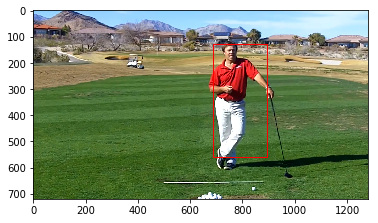

In [7]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_01)

# Create a Rectangle patch
rect = patches.Rectangle((687.64548803,125.95119705),205.08287293,433.73848987,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [11]:
len(vid_info_list[0][2])

14

In [12]:
vid_info_list[0][2][3]

array([[ 687.64548803,  652.28637201,  659.35819521,  659.35819521,
         697.07458564,  652.28637201,  744.22007366,  657.00092081],
       [ 290.96040516,  290.96040516,  288.60313076,  302.74677716,
         314.53314917,  290.96040516,  290.96040516,  326.31952118]])

In [13]:
vid = np.random.choice(len(vid_info_list), 1)[0]

vid_bbox = vid_info_list[vid][1]
vid_x = vid_info_list[vid][2]
vid_path = vid_info_list[vid][3]

# 2. choose pair of frames
n_frames = vid_x.shape[2]
frames = np.random.choice(n_frames, 2, replace=False)
while abs(frames[0] - frames[1]) / (n_frames * 1.0) <= 0.02:
    frames = np.random.choice(n_frames, 2, replace=False)

In [14]:
n_frames

8

In [15]:
frames

array([1, 2])

In [16]:
joints = vid_x[:, :, 0] - 1.0
box_frame = vid_bbox[0, :]
scale = data_generation.get_person_scale(joints)
pos = np.zeros(2)
pos[0] = (box_frame[0] + box_frame[2] / 2.0)
pos[1] = (box_frame[1] + box_frame[3] / 2.0)

In [17]:
joints

array([[ 750.29189687,  124.95119705],
       [ 755.00644567,  202.7412523 ],
       [ 705.50368324,  238.10036832],
       [ 686.64548803,  289.96040516],
       [ 724.36187845,  301.74677716],
       [ 806.8664825 ,  209.81307551],
       [ 856.36924494,  252.24401473],
       [ 891.72836096,  297.03222836],
       [ 722.00460405,  348.89226519],
       [ 731.43370166,  464.39871087],
       [ 747.93462247,  558.68968692],
       [ 785.65101289,  360.6786372 ],
       [ 785.65101289,  473.82780847],
       [ 719.64732965,  546.90331492]])

In [18]:
box_frame

array([ 687.64548803,  125.95119705,  205.08287293,  433.73848987])

In [19]:
scale

2.8729281767955799

In [20]:
params = param.get_general_params()

In [21]:
params

{'IMG_HEIGHT': 256,
 'IMG_WIDTH': 256,
 'batch_size': 4,
 'data_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/data',
 'limbs': [[0, 1],
  [2, 3],
  [3, 4],
  [5, 6],
  [6, 7],
  [8, 9],
  [9, 10],
  [11, 12],
  [12, 13],
  [2, 5, 8, 11]],
 'max_px_shift': 10,
 'max_rotate_degree': 5,
 'max_sat_factor': 0.05,
 'model_save_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018/models',
 'model_save_interval': 1000,
 'n_joints': 14,
 'n_limbs': 10,
 'n_training_iter': 200000,
 'obj_scale_factor': 1.14,
 'posemap_downsample': 2,
 'project_dir': '/mnt/data/jarvislam1999/posewarp-cvpr2018',
 'scale_max': 1.05,
 'scale_min': 0.9,
 'sigma_joint': 1.75,
 'test_interval': 500}

In [33]:
vid_info_list

[[{'__globals__': [],
   '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Jan 28 13:13:59 2018',
   '__version__': '1.0',
   'data': array([[ (array([[[ 751.29189687,  727.71915285,  715.93278085,  704.14640884,
             706.50368324,  645.2145488 ,  723.00460405,  692.36003683],
           [ 125.95119705,  118.87937385,  130.66574586,  140.09484346,
             142.45211786,  128.30847145,  125.95119705,  137.73756906]],
   
          [[ 756.00644567,  734.79097606,  727.71915285,  706.50368324,
             713.57550645,  664.07274401,  734.79097606,  711.21823204],
           [ 203.7412523 ,  201.3839779 ,  215.52762431,  222.59944751,
             224.95672192,  213.17034991,  208.4558011 ,  227.31399632]],
   
          [[ 706.50368324,  675.85911602,  685.28821363,  668.78729282,
             673.50184162,  623.99907919,  697.07458564,  666.43001842],
           [ 239.10036832,  232.02854512,  224.95672192,  234.38581952,
             246.17219153,  232

In [53]:
train_feed = data_generation.warp_example_generator(vid_info_list, params)

In [54]:
train_feed

<generator object warp_example_generator at 0x7ffb94c9efc0>

In [55]:
x, y = next(train_feed)

In [56]:
len(x)

5

In [57]:
len(y)

4

In [58]:
x

[array([[[[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          ..., 
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.23600185,  0.14705991,  0.04333356],
          [ 0.37760296,  0.23903149,  0.07313996],
          [ 0.37760296,  0.23951941,  0.07548426],
          ..., 
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.62752078,  0.37764329,  0.10660923],
          [ 1.        ,  0.61760177,  0.18227801],
          [ 1.        ,  0.63905068,  0.20933668],
          ..., 
          [ 0.62933827,  0.51409174,  0.3117163 ],
          [ 0.23600185,  0.19342897,  0.11753818],
          [ 0.        ,  0.        ,  0.        ]],
 
         ..., 
         [

In [59]:
y

array([[[[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         ..., 
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.23595476,  0.14694218,  0.05441598],
         [ 0.37757471,  0.23349868,  0.08543322],
         [ 0.37760296,  0.23613111,  0.09167951],
         ..., 
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.62925953,  0.38282864,  0.13970367],
         [ 1.        ,  0.60804833,  0.22267742],
         [ 1.        ,  0.62578037,  0.25592996],
         ..., 
         [ 0.62933827,  0.49284949,  0.24926731],
         [ 0.23600185,  0.18417399,  0.09347524],
         [ 0.        ,  0.        ,  0.        ]],

        ..., 
        [[-0.69329899, -0.1715862 ,

In [60]:
x[0]

array([[[[ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         ..., 
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.23600185,  0.14705991,  0.04333356],
         [ 0.37760296,  0.23903149,  0.07313996],
         [ 0.37760296,  0.23951941,  0.07548426],
         ..., 
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ]],

        [[ 0.62752078,  0.37764329,  0.10660923],
         [ 1.        ,  0.61760177,  0.18227801],
         [ 1.        ,  0.63905068,  0.20933668],
         ..., 
         [ 0.62933827,  0.51409174,  0.3117163 ],
         [ 0.23600185,  0.19342897,  0.11753818],
         [ 0.        ,  0.        ,  0.        ]],

        ..., 
        [[-0.59501331, -0.11998493,

In [61]:
x_ = np.array(x[0])

In [62]:
x_.shape

(4, 256, 256, 3)

In [63]:
img_x = Image.fromarray(x_[1], 'RGB')

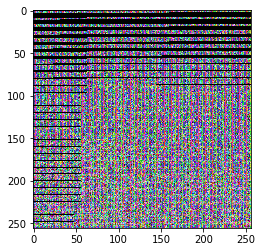

In [64]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img_x)

plt.show()